In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import sklearn.calibration
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
from functools import partial
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from scipy.stats import percentileofscore
from copy import deepcopy
from sklearn.metrics import confusion_matrix
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import viz

# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
outcome_def = 'successful_full'
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta, normalize=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
df = dfs[list(dfs.keys())[0]]
X = df[feat_names[:p]]
y = df['y_consec_thresh']


# add preds
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
# df = dfs[('clath_aux+gak_new', 'test')]
df['preds'] = dnn.predict(df[feat_names[:1]])
df = df.sort_values(by='preds')
x = df[feat_names[:1]]
y = df['y_consec_thresh'].values
preds = dnn.predict(x)
n = df.shape[0]

# sort things
print(f'acc {np.mean((preds > 0) == y):0.3f} vs baseline {1-np.mean(y):0.2f}', )

100%|██████████| 1/1 [00:52<00:00, 52.30s/it]


type <class 'dict'>
acc 0.841 vs baseline 0.65


# errs in different regions

## acc for different lifetimes

In [104]:
d = df[df['lifetime'] > 15]
y = d[outcome_def].astype(bool)
p = d['preds'].values > 0
l = d['lifetime'].values

nbins = 6
quantiles = [np.quantile(l, frac) for frac in np.linspace(0, 1, nbins)]
print('quantiles', quantiles)
# for ind in tqdm(np.arange(1, nbins + 1)):
for i in range(nbins):
    if i == 0:
        left = 0
    else:
        left = quantiles[i - 1]
    right = quantiles[i]
    idxs = np.logical_and(left < l,  l <= right)
    print(idxs)
    print('npts', idxs.sum())
    accs.append(np.mean((y==p)[idxs]))
    base = np.mean(y[idxs])
    accs_b.append(max(base, 1 - base))
    
#labels
quantiles = [15] + quantiles
s = [f'{quantiles[i]}-{quantiles[i + 1]}' for i in range(nbins)]  


quantiles [16.5, 18.0, 22.5, 30.0, 51.0, 271.5]
[False  True False ... False False False]
npts 1020
[False False False ... False False False]
npts 814
[ True False  True ... False False False]
npts 1727
[False False False ... False False False]
npts 1583
[False False False ...  True  True False]
npts 1677
[False False False ... False False  True]
npts 1636


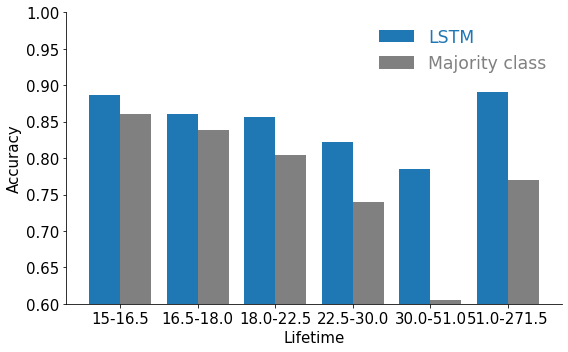

In [105]:
plt.figure(figsize=(8, 5))
W = 0.4
# plt.grid()
plt.bar(np.arange(nbins), accs, width=W, label='LSTM')
plt.bar(np.arange(nbins) + W, accs_b, color='gray', width=W, label='Majority class')
plt.xticks(np.arange(nbins) + W / 2, labels=s)
plt.xlabel('Lifetime')
plt.ylabel('Accuracy')
plt.legend(fontsize='xx-large', frameon=False, labelcolor='linecolor')
plt.ylim((0.6, 1.0))
viz.savefig('acc_by_lifetime')

## cumulative acc across everything

In [79]:
# currently trained only on 'clath_aux+gak_a7d2_new'
# dsets = ['clath_aux+gak_new']
dsets = ['clath_aux_dynamin']
splits = ['test']
# feat_names = ['X_same_length_normalized'] # + data.select_final_feats(data.get_feature_names(df))

#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs, feat_names = data.load_dfs_for_lstm(dsets=dsets, splits=splits, meta=meta,
                                         normalize=False, filter_short=False)
print('type', type(dfs))
# load model
p = 1
results = pkl.load(open(config.FINAL_MODEL, 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')
dnn.model.load_state_dict(results['model_state_dict'])

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
# df = dfs[('clath_aux+gak_new', 'test')]
dd = dfs[list(dfs.keys())[0]]
dd = dd[dd.short]
dfull = pd.concat((df, dd), axis=0)
dfull['preds_proba'] = dnn.predict(dfull[feat_names[:1]]) + 2 * (dfull['X_max'] < 1500)
dfull['preds'] = np.logical_and(dfull['preds_proba'].values > 0,
                                dfull['X_max'] > 1500).astype(int)

100%|██████████| 1/1 [01:57<00:00, 117.49s/it]


type <class 'dict'>


accsf 36110
(40310,) (31853,) (8457,) (40310,)
[1 1 1 ... 1 0 1]


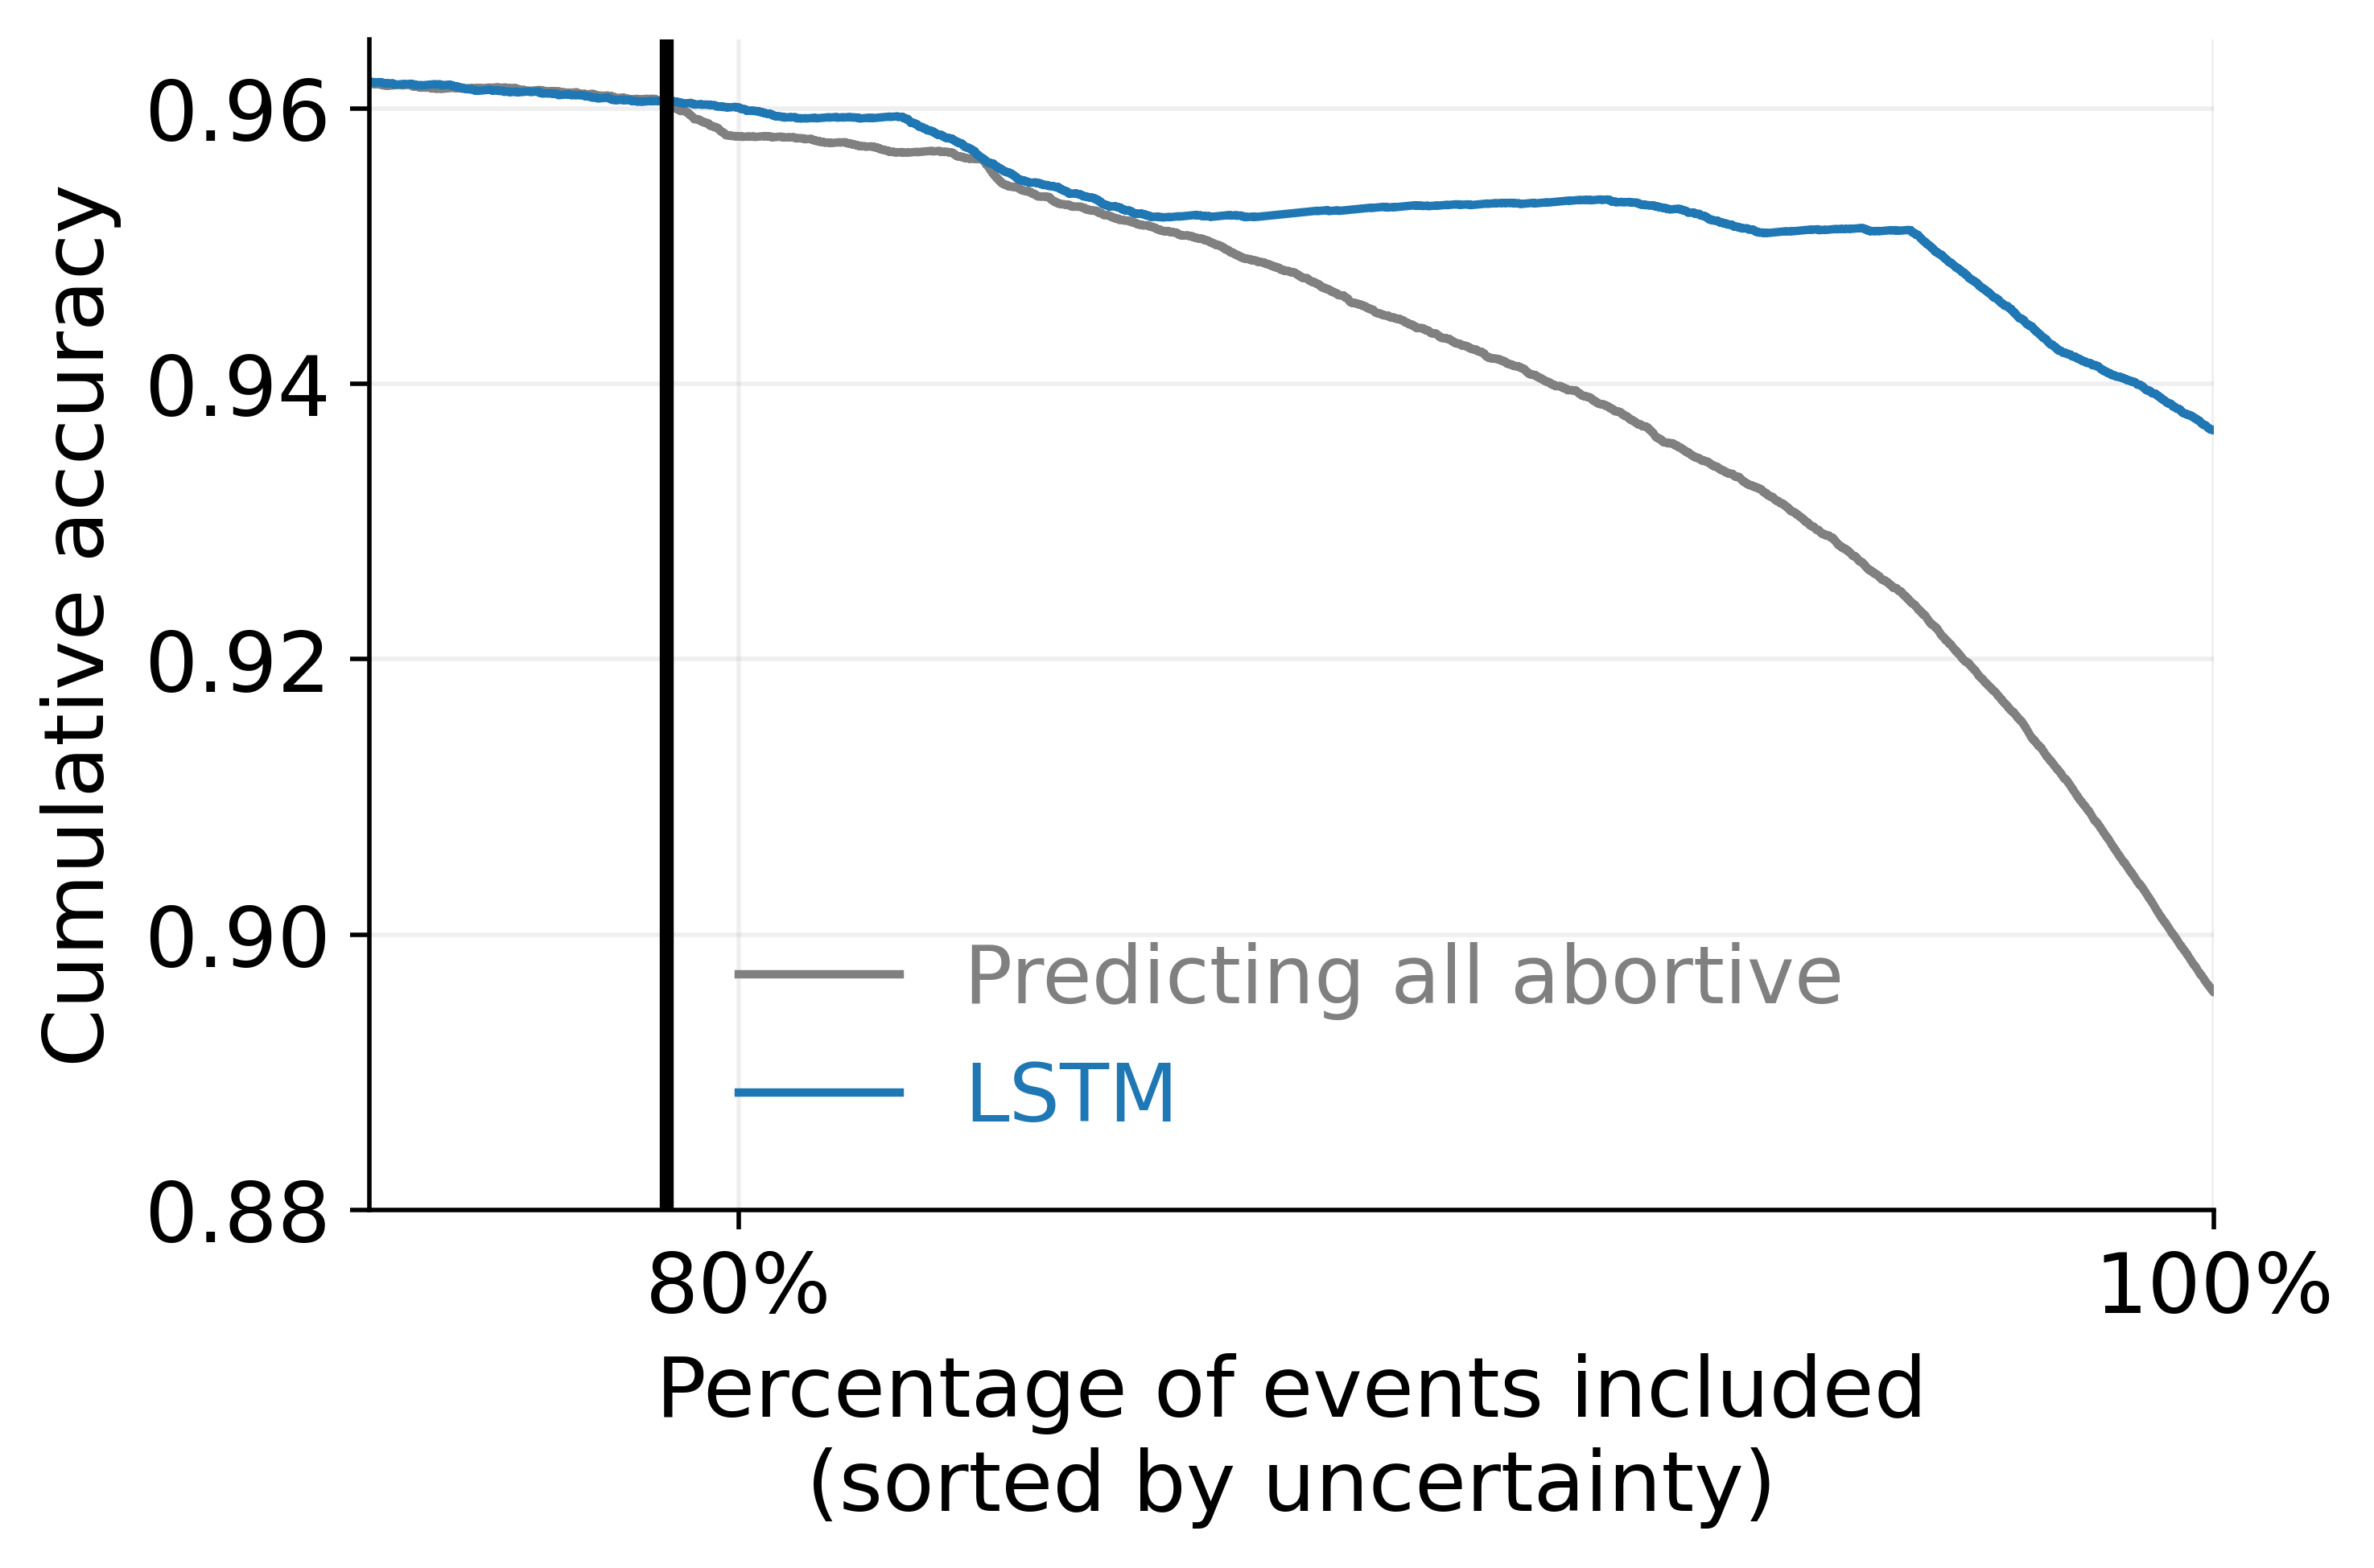

In [80]:
outcome_def = 'successful_dynamin'
viz.cumulative_acc_plot_all(df=dfull,
                            pred_proba_key='preds_proba',
                            pred_key='preds',
                            outcome_def=outcome_def, show=False)
plt.xlabel('Percentage of events included\n(sorted by uncertainty)')
plt.ylabel('Cumulative accuracy')
plt.xlim((dfull.shape[0]*3/4, dfull.shape[0]))
plt.ylim((0.88, 0.965))
viz.savefig('cum_acc')